# Music genre classification (Decision Tree, Logistic Regression, SVM).
F-1 score ~0.95

### Importing dependencies and data.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

In [2]:
# importing data & merging cols
echonest = pd.read_json(os.path.join('datasets', 'echonest-metrics.json'), precise_float=True)
songs = pd.read_csv(os.path.join('datasets', 'fma-rock-vs-hiphop.csv'))

tracks = pd.merge(songs[['track_id', 'genre_top']], echonest, on='track_id').drop('track_id', axis=1)
tracks.head()

genre_top  acousticness  danceability    energy  instrumentalness  liveness  \
0      Rock      0.988306      0.255661  0.979774          0.973006  0.121342   
1      Rock      0.970135      0.352946  0.023852          0.957113  0.113261   
2      Rock      0.981657      0.142249  0.912122          0.967294  0.363510   
3      Rock      0.989141      0.225978  0.722835          0.263076  0.092371   
4      Rock      0.886660      0.298518  0.744333          0.920950  0.139587   

   speechiness   tempo   valence  
0     0.051740  90.241  0.034018  
1     0.032177  53.758  0.035632  
2     0.087527  91.912  0.034325  
3     0.053406  94.322  0.028347  
4     0.088781  97.880  0.073548

### Exploring data

In [3]:
# let's see data info
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre_top         4802 non-null   object 
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
dtypes: float64(8), object(1)
memory usage: 337.8+ KB


In [4]:
tracks.isna().sum().sum()

0

In [5]:
tracks.genre_top.value_counts()

genre_top
Rock       3892
Hip-Hop     910
Name: count, dtype: int64

As we can see, data has no missing values.
But also, data has imbalanced classes. There are way more Rock records than Hip-Hop's. We might consider upsampling.
For now, let's push the analysys further.

In [55]:
# let's check correlation between features
correlation_matrix = tracks.drop(['genre_top'], axis=1).corr()
correlation_matrix.style.background_gradient(cmap='crest')

As we can see, there are no high correlations in this data, thus we cannot reduce the dimensionality that easily.

/Users/detker/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/detker/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/detker/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/detker/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

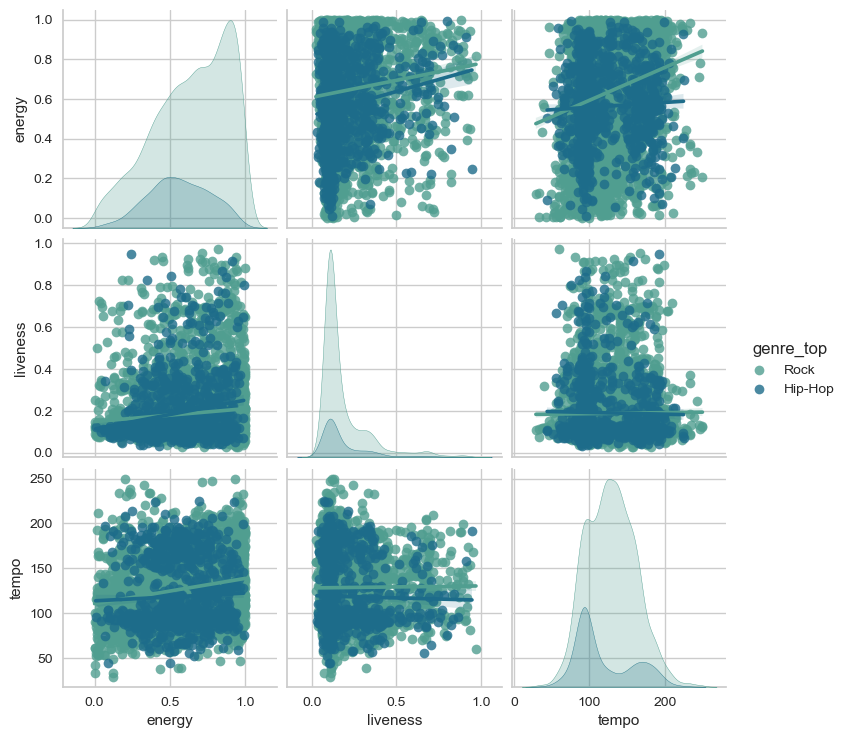

In [54]:
# data validation plots, only to check if it does makes sense.
vars_plot = ['energy', 'liveness', 'tempo']
pairplot = sns.pairplot(tracks, vars=vars_plot, hue='genre_top', kind='reg', palette='crest')
fig = pairplot.fig
fig.savefig(os.path.join('charts', 'pairplot_datacheck.png'), dpi=300)

Now, we can plot RadViz plot to see better which features are more significant for each sample.

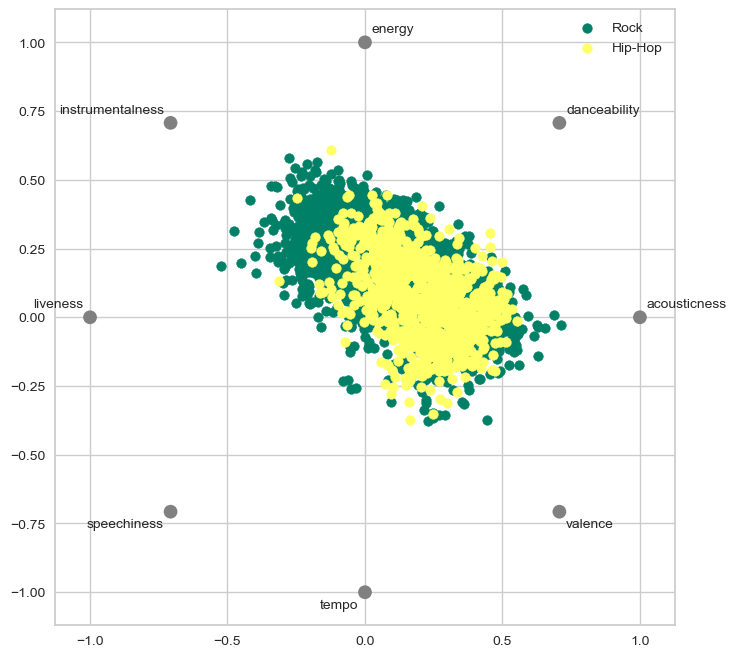

In [82]:
fig, ax = plt.subplots(figsize=(8, 8))
pd.plotting.radviz(tracks, 'genre_top', ax=ax, colormap='summer')
fig.savefig(os.path.join('charts', 'radviz_without_upsampling.png'), dpi=300)

### Upsampling data

In [13]:
# let's upsample hip-hop data
from sklearn.utils import resample
mask = tracks['genre_top'] == 'Hip-Hop'
hip_hop_tracks = tracks[mask]
rock_tracks = tracks[~mask]
tracks_upsample = resample(hip_hop_tracks, replace=True, n_samples=len(rock_tracks), random_state=42)
upsampled_tracks = pd.concat([rock_tracks, tracks_upsample])
upsampled_tracks['genre_top'].value_counts()

genre_top
Rock       3892
Hip-Hop    3892
Name: count, dtype: int64

After we upsampled data, we can plot RadViz again to see if new generated data is well-structured.

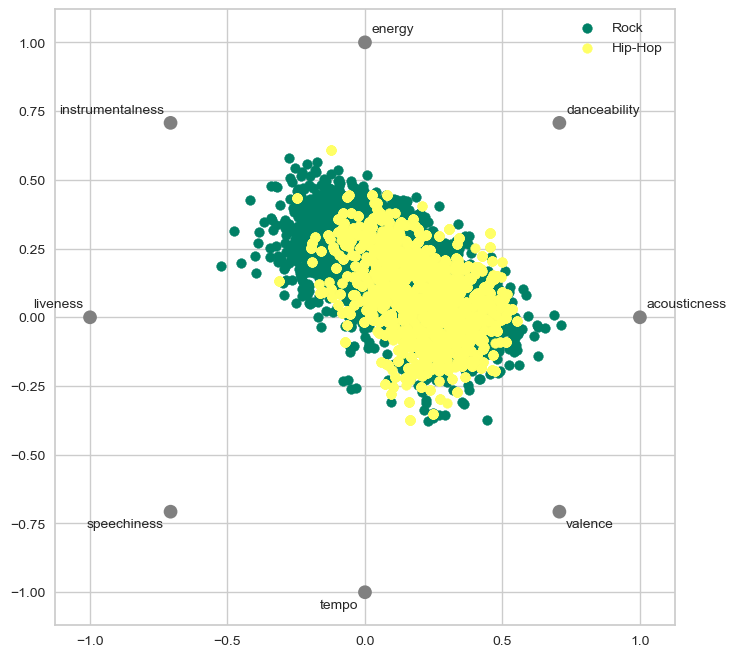

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))
pd.plotting.radviz(upsampled_tracks, 'genre_top', ax=ax, colormap='summer')
fig.savefig(os.path.join('charts', 'radviz_upsampled.png'), dpi=300)

### PCA (and normalization)

In [17]:
# let's do PCA, but first we need to normalize the data.
from sklearn.preprocessing import StandardScaler
features = upsampled_tracks.drop('genre_top', axis=1)
labels = upsampled_tracks['genre_top']

scaler = StandardScaler()
features = scaler.fit_transform(features)

<BarContainer object of 8 artists>

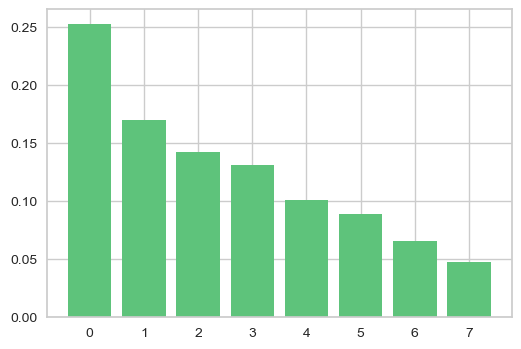

In [86]:
# now we are ready to perform PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(features)
exp_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(pca.n_components_), exp_variance, color='#5EC37B')

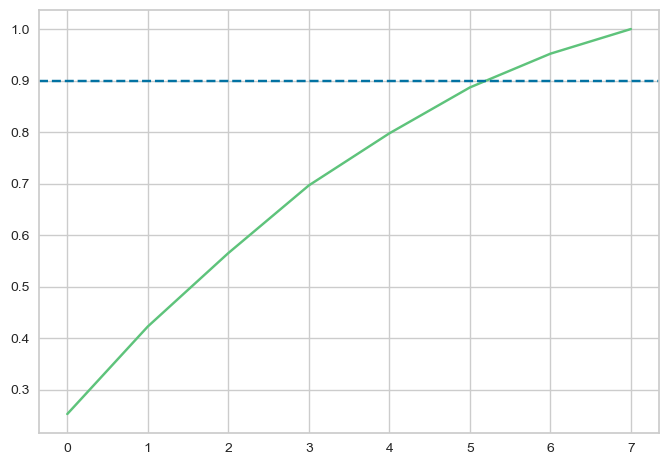

In [87]:
cum_exp_variance = np.cumsum(exp_variance)
fig, ax = plt.subplots()
ax.plot(cum_exp_variance, color='#5EC37B')
ax.axhline(y=0.9, linestyle='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(features)
pca_projection = pca.transform(features)

### The Decision Tree Model

In [30]:
# FITTING TIME

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pca_projection, labels, random_state=42)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

with open('model.bin', 'wb') as fh:
    pickle.dump(tree, fh)

### Evaluation

              precision    recall  f1-score   support

     Hip-Hop       0.90      0.99      0.94       981
        Rock       0.99      0.89      0.94       965

    accuracy                           0.94      1946
   macro avg       0.95      0.94      0.94      1946
weighted avg       0.95      0.94      0.94      1946



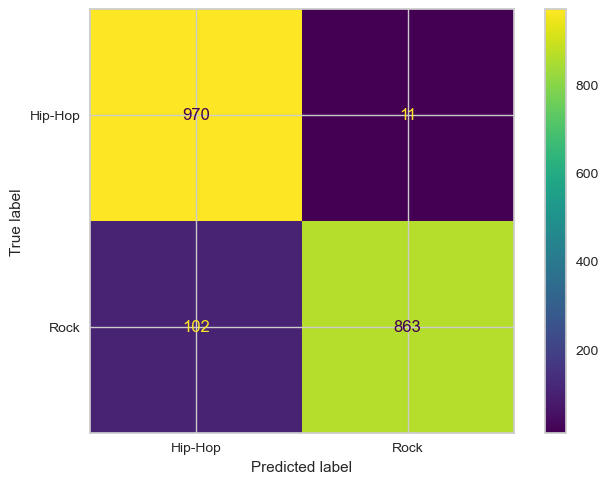

In [89]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_hat = tree.predict(X_test)
report = classification_report(y_test, y_hat)
coff_mat = confusion_matrix(y_test, y_hat)

print(report)
disp = ConfusionMatrixDisplay(coff_mat, display_labels=tree.classes_)
disp.plot()

As we can see, we scored pretty high with Decision Tree. Confusion matrix revaled that our model perform very well, but sometimes it takes Rock song as Hip-Hop. On the other hand, the inverse situation practically does not happen. It's because Rock songs are way more marked/intensive. It has an effect on features values. Below is plotted a chart representing feature importances in our model.

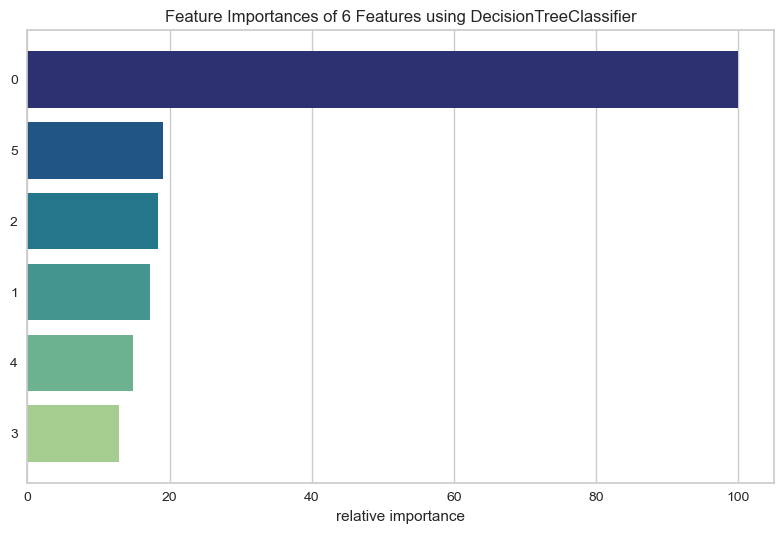

In [91]:
from yellowbrick.features import FeatureImportances

fi_viz = FeatureImportances(tree, colormap='crest')
fi_viz.fit(X_train, y_train)
fi_viz.poof()
fi_viz.fig.savefig(os.path.join('charts', 'feature_importances_tree_model.png'), dpi=300)

### Let's check other model's performance

In [33]:
#let's check how standard logistic regression perform.
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

     Hip-Hop       0.82      0.82      0.82       981
        Rock       0.82      0.82      0.82       965

    accuracy                           0.82      1946
   macro avg       0.82      0.82      0.82      1946
weighted avg       0.82      0.82      0.82      1946



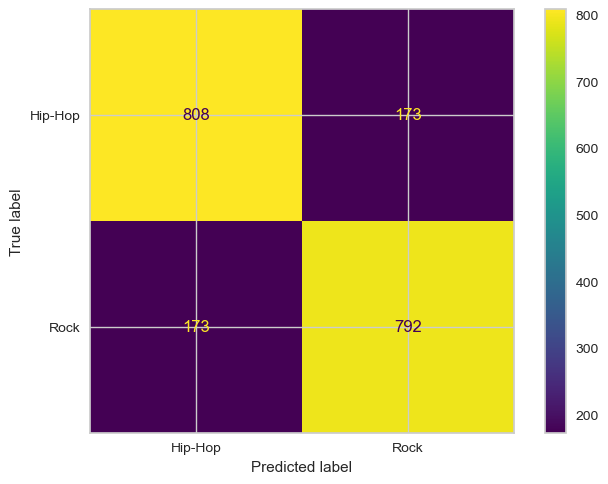

In [34]:
y_hat = model.predict(X_test)
report = classification_report(y_test, y_hat)
coff_mat = confusion_matrix(y_test, y_hat)

print(report)
disp = ConfusionMatrixDisplay(coff_mat, display_labels=model.classes_)
disp.plot()

In [35]:
# And last but not least - supported vector machine
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

SVC()

              precision    recall  f1-score   support

     Hip-Hop       0.87      0.87      0.87       981
        Rock       0.87      0.87      0.87       965

    accuracy                           0.87      1946
   macro avg       0.87      0.87      0.87      1946
weighted avg       0.87      0.87      0.87      1946



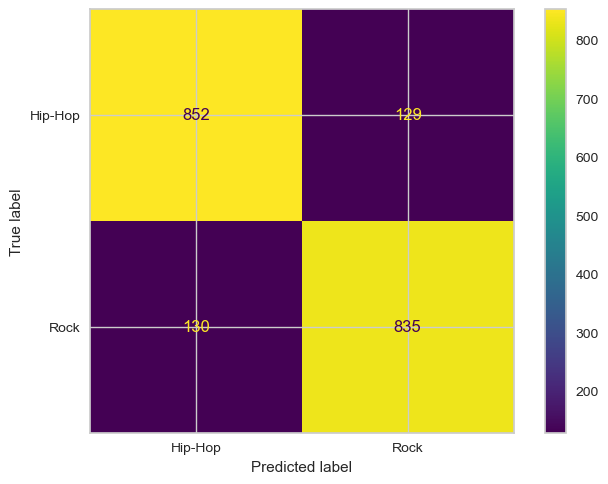

In [36]:
y_hat = svc.predict(X_test)
report = classification_report(y_test, y_hat)
coff_mat = confusion_matrix(y_test, y_hat)

print(report)
disp = ConfusionMatrixDisplay(coff_mat, display_labels=svc.classes_)
disp.plot()

### So, we can see that from those 3 models, decision tree performs the best with ~0.95 f-1 score.
Let's visualize the tree model.

In [38]:
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, class_names=tree.classes_, filled=True)
g = pydotplus.graph_from_dot_data(dot_data.getvalue())
g.write_png(os.path.join('charts', 'tree_model_viz.png'))
Image(g.create_png())